In [1]:
import gc
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import itertools
from sklearn.metrics import confusion_matrix

from create_data import create_dataframe

import keras
import keras.backend as K

from keras.layers import (
    Dense, 
    Flatten, 
    Activation, 
    Conv2D, 
    MaxPooling2D, 
    Dropout, 
    BatchNormalization, 
    Bidirectional,
    ConvLSTM2D,
    LeakyReLU,
    MaxPooling1D,
    Conv1D,
    GRU, 
    SimpleRNN,
    LSTM,
    Dropout,
    Reshape,
    Input,
    Masking,
    Permute, 
    GlobalAveragePooling1D,
    GlobalMaxPooling1D
)


from keras.utils import to_categorical

from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from keras_utils import AttentionLSTM

Using TensorFlow backend.


## Create train/val/test data 

In [2]:
def concat_to_stack(all_data, id_data, stack_num=1):
    """
    Объеденить данные в стек
    
    :param all_data: numpy array: все значения датабазы (с углами)
    :param id_data: numpy array: метки к датабазе 
    :param stack_num: int: количество элементов в стеке
    
    :retrun: массив стеков и метки к ним
    """
    new_data = []
    new_id = []
    
    # найти все уникальные метки классов
    all_un_id = np.unique(id_data)
    for idx in all_un_id:
        # найти все индексы с текущей меткой
        all_cur_idx = id_data[id_data == idx]
        
        all_cur_data = all_data[id_data == idx]
        tmp_data = []  # массив для новых стеков
        for j in range(len(all_cur_data)- stack_num):
            tmp = all_cur_data[j:j+stack_num].reshape(all_data.shape[1], stack_num)
            tmp_data.append(tmp)
            
        new_data.append(tmp_data)
        new_id.append([idx] * len(tmp_data))
        
        
    new_id = np.array(list(itertools.chain.from_iterable(new_id)))
#     print(new_id.shape)
    new_data = np.array(list(itertools.chain.from_iterable(new_data)))
#     print(new_data.shape)
    
    return new_data, new_id

In [3]:
def one_hot_encode(labels, num_unq_labels, num_examples):
    ohe_label = np.eye(N=num_examples, M=num_unq_labels, dtype=np.float32)[labels]
    return ohe_label

def prepare_dataframe(cur_model_type, is_y_cat=False, is_use_angles=False, stack_num=1):
    """
    Подготовить x, y данные для генератора данных, где
        x - массив данных 
        y - метки объектов
    :param cur_model_type: str: один из типов данных для тренировки:
                                * 'all_types' - данные и метки к ним это типы целей
                                * 'drone' - данные и метки к ним это классы внтури типа 'drone'
                                * 'fighter' - данные и метки к ним это классы внтури типа 'fighter'
                                * 'helicopter' - данные и метки к ним это классы внтури типа 'helicopter'
                                * 'missile' - данные и метки к ним это классы внтури типа 'missile'
                                * 'all_classes' - данные и метки всех классов каждого типа
    :param is_y_cat: bool: привести метки объектов в формат OHE, если значение True и оставить значения при False
    :param is_use_angles: добавить значение углов обзора цели, если значение True и оставить только амплитуды при False
    :param stack_num: int: количество элементов в стеке
                            
    :return: data_train_val_test: tuple: список с парами x, y для train, val, test стадий обучения соответственно
    """
    
    print(cur_model_type, is_y_cat, is_use_angles)
    
    # загрузить датасет
    if os.path.exists('../input/ALLdata_cl14.pkl'):  # уже готовый
        df = pd.read_pickle('../input/ALLdata_cl14.pkl')

    else:  # если не существует, то создать и сохранить
        df = create_dataframe(is_normalize=False)
        df.to_pickle('../../input/ALLdata_cl14.pkl')

    # ===============================================
    # Выберем через каждые 5 портретов для валидации
    # Каждый 5 из валидации идет в тест
    # Все остальное для тренировки
    # ===============================================

    if cur_model_type in ['all_types', 'all_classes']:
        cur_data = df  # все данные
    elif cur_model_type in  ['drone', 'fighter', 'helicopter', 'missile']:
        cur_data = df[df.Model_type == cur_model_type]  # заданный тип цели
    else:
        raise TypeError('введите тип данных для подготовки')

    # разделение данных (БЕЗ ПЕРЕМЕШИВАНИЯ)
    val_data = cur_data.loc[1::5]
    train_data = cur_data.drop(val_data.index, axis=0)
    test_data = val_data.loc[1::5]
    val_data = val_data.drop(test_data.index, axis=0)

    # Контрольная проверка размерностей
    print(f'Train shape: {train_data.shape}\n' 
          f'Val shape: {val_data.shape}\n'
          f'Test shape: {test_data.shape}')

    print(f'Current model types: {np.unique(cur_data.Model_type)}')

    # ===============================================
    # Приведение к обучающему формату для keras
    # ВЫБРАТЬ ТИП ДЛЯ КЛАССИФИКАЦИИ: Id_class - класс целей, Id_Model_type - тип цели
    # ===============================================

    # === TRAIN ===
    x_train = train_data.RCS
    x_train = np.array([elem for elem in x_train])
    # Добавить значения углов обзора к обучающей выборке
    x_train = np.hstack((x_train, 
                             train_data['1_angle'].values.reshape(-1, 1), 
                             train_data['2_angle'].values.reshape(-1, 1))) if is_use_angles else x_train
    
    x_train = x_train.reshape(x_train.shape[0], -1, 1)
    # привести метки к заданному формату
    if cur_model_type == 'all_types':  # метки типов целей
        y_train = train_data.Id_Model_type

    elif cur_model_type == 'all_classes':  # метки всех классов
        y_train = train_data.Id_class
#         tmp = np.unique(train_data.Model_name.values)
#         print({model: idx for idx, model in enumerate(tmp)})

    elif cur_model_type in ['drone', 'fighter', 'helicopter', 'missile']: # метки внутри типа цели
        # привести к OHE 
        y_train = train_data.Model_name
        classes = np.unique(y_train.values)
        mapping_types = {model: idx for idx, model in enumerate(classes)}
        y_train = y_train.replace(mapping_types)  # заменить текущие имена на метку(число)

    # === VALIDATION ===
    x_val = val_data.RCS
    x_val = np.array([elem for elem in x_val])
    # Добавить значения углов обзора к обучающей выборке
    x_val = np.hstack((x_val, 
                             val_data['1_angle'].values.reshape(-1, 1), 
                             val_data['2_angle'].values.reshape(-1, 1))) if is_use_angles else x_val
    
    x_val = x_val.reshape(x_val.shape[0], -1, 1)
    # привести метки к заданному формату
    if cur_model_type == 'all_types':  # метки типов целей
        y_val = val_data.Id_Model_type
        
    elif cur_model_type == 'all_classes':  # метки всех классов
        y_val = val_data.Id_class
        
    elif cur_model_type in ['drone', 'fighter', 'helicopter', 'missile']: # метки внутри типа цели
        # привести к OHE 
        y_val = val_data.Model_name
        classes = np.unique(y_val.values)
        mapping_types = {model: idx for idx, model in enumerate(classes)}
        y_val = y_val.replace(mapping_types) # заменить текущие имена на метку(число)

    # === TEST ===
    x_test = test_data.RCS
    x_test = np.array([elem for elem in x_test])
    # Добавить значения углов обзора к обучающей выборке
    x_test = np.hstack((x_test, 
                             test_data['1_angle'].values.reshape(-1, 1), 
                             test_data['2_angle'].values.reshape(-1, 1))) if is_use_angles else x_test
    
    x_test = x_test.reshape(x_test.shape[0], -1, 1)
    # привести метки к заданному формату
    if cur_model_type == 'all_types':  # метки типов целей
        y_test = test_data.Id_Model_type
        
    elif cur_model_type == 'all_classes':  # метки всех классов
        y_test = test_data.Id_class
    
    elif cur_model_type in ['drone', 'fighter', 'helicopter', 'missile']: # метки внутри типа цели
        # привести к OHE 
        y_test = test_data.Model_name
        classes = np.unique(y_test.values)
        mapping_types = {model: idx for idx, model in enumerate(classes)}
        y_test = y_test.replace(mapping_types)

    # === Соеденить данные в стек === 
    x_train, y_train = concat_to_stack(x_train, y_train, stack_num)
    x_val, y_val = concat_to_stack(x_val, y_val, stack_num)
    x_test, y_test = concat_to_stack(x_test, y_test, stack_num)
        
    # === Кодирование меток ===
    num_classes = len(np.unique(y_train))
    if is_y_cat:
        print(y_train)
        y_train = one_hot_encode(y_train, num_classes, y_train.shape[0])
        y_val = one_hot_encode(y_val, num_classes, y_val.shape[0])
        y_test = one_hot_encode(y_test, num_classes, y_test.shape[0])

    # === Контрольная проверка размерностей === 
    print(f'Train shape: {x_train.shape, y_train.shape}\n' 
          f'Val shape: {x_val.shape, y_val.shape}\n'
          f'Test shape: {x_test.shape, y_test.shape}')

    # === Собрать данные для выходного формата === 
    data_train_val_test = [(x_train, y_train),
                           (x_val, y_val),
                           (x_test, y_test)
                          ]

    return data_train_val_test

# Data engineering 

In [4]:
cur_model_type = 'all_classes'
stack_num = 3
train_xy, val_xy, test_xy = prepare_dataframe(cur_model_type=cur_model_type, 
                                              is_y_cat=True, is_use_angles=False, stack_num=stack_num)

x_train, y_train = train_xy
x_val, y_val = val_xy
x_test, y_test = test_xy

if x_train.shape[1] == 102:
    x_train, x_train_angle = x_train[:, :-2], x_train[:, -2:].reshape((-1, 2, stack_num))
    x_val, x_val_angle = x_val[:, :-2], x_val[:, -2:].reshape((-1, 2, stack_num))
    x_test, x_test_angle = x_test[:, :-2], x_test[:, -2:].reshape((-1, 2, stack_num))
    
    print('\n=========== TEST (separate rcs data and angles) ==============')
    print(f'Train shape: {x_train.shape, y_train.shape}\n' 
          f'Val shape: {x_val.shape, y_val.shape}\n'
          f'Test shape: {x_test.shape, y_test.shape}')

    print(f'Train angles shape: {x_train_angle.shape}\n' 
          f'Val angles shape: {x_val_angle.shape}\n'
          f'Test angles shape: {x_test_angle.shape}')

all_classes True False
Train shape: (30210, 8)
Val shape: (6042, 8)
Test shape: (1511, 8)
Current model types: ['drone' 'fighter' 'helicopter' 'missile']
[ 0  0  0 ... 13 13 13]
Train shape: ((30168, 100, 3), (30168, 14))
Val shape: ((6000, 100, 3), (6000, 14))
Test shape: ((1469, 100, 3), (1469, 14))


## NN model 

# Version 1 (Inception+LSTM) 

In [7]:
# CONV1D LSTM

def inception_module_1D(x,
                        filters_1x1,
                        filters_3x3_reduce,
                        filters_3x3,
                        filters_5x5_reduce,
                        filters_5x5,
                        filters_pool_proj,
                        name=None):

    tower_1_x1 = Conv1D(filters=filters_1x1, kernel_size=1, padding='same', activation='relu')(x)

    tower_2_x3 = Conv1D(filters=filters_3x3_reduce, kernel_size=3, padding='same', activation='relu')(x)
    tower_2_x3 = Conv1D(filters=filters_3x3, kernel_size=3, padding='same', activation='relu')(tower_2_x3)
    
    tower_3_x5 = Conv1D(filters=filters_5x5_reduce, kernel_size=5, padding='same', activation='relu')(x)
    tower_3_x5 = Conv1D(filters=filters_5x5, kernel_size=5, padding='same', activation='relu')(tower_3_x5)

    tower_4_pool = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)
    tower_4_pool = Conv1D(filters=filters_pool_proj, kernel_size=1, padding='same', activation='relu')(tower_4_pool)

    inc_tower = keras.layers.concatenate([tower_1_x1, 
                                          tower_2_x3, 
                                          tower_3_x5, 
                                          tower_4_pool], axis=2, name=name)
    
    return inc_tower

input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]))

x = input_layer
x = inception_module_1D(x, 100, 16, 32, 32, 64, 64, name='inception_1a')
# x = Bidirectional(LSTM(64, dropout=0.2, return_sequences=True))(x)
x = Bidirectional(LSTM(128, dropout=0.2))(x)
x = Dense(64, activation=LeakyReLU(alpha=0.1))(x)
x = Dense(y_train.shape[1], activation='softmax')(x)

conv1d_model = Model(input_layer, x, name='InceptionDP_v2')

optimizer = keras.optimizers.RMSprop(lr=1e-3, decay=1e-5)
conv1d_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [6]:
conv1d_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 3)       0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 100, 16)      160         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 100, 32)      512         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 100, 3)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (

# Version 1* (Inception+LSTM) с углами

In [ ]:
# CONV1D LSTM

def inception_module_1D(x,
                        filters_1x1,
                        filters_3x3_reduce,
                        filters_3x3,
                        filters_5x5_reduce,
                        filters_5x5,
                        filters_pool_proj,
                        name=None):

    tower_1_x1 = Conv1D(filters=filters_1x1, kernel_size=1, padding='same', activation='relu')(x)

    tower_2_x3 = Conv1D(filters=filters_3x3_reduce, kernel_size=3, padding='same', activation='relu')(x)
    tower_2_x3 = Conv1D(filters=filters_3x3, kernel_size=3, padding='same', activation='relu')(tower_2_x3)
    
    tower_3_x5 = Conv1D(filters=filters_5x5_reduce, kernel_size=5, padding='same', activation='relu')(x)
    tower_3_x5 = Conv1D(filters=filters_5x5, kernel_size=5, padding='same', activation='relu')(tower_3_x5)

    tower_4_pool = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)
    tower_4_pool = Conv1D(filters=filters_pool_proj, kernel_size=1, padding='same', activation='relu')(tower_4_pool)

    inc_tower = keras.layers.concatenate([tower_1_x1, 
                                          tower_2_x3, 
                                          tower_3_x5, 
                                          tower_4_pool], axis=2, name=name)
    
    return inc_tower

input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]))
input_angles = Input(shape=(x_train_angle.shape[1], x_train_angle.shape[2]))

x = input_layer
x = inception_module_1D(x, 100, 16, 32, 32, 64, 64, name='inception_1a')
# x = Bidirectional(LSTM(64, dropout=0.2, return_sequences=True))(x)
x = Bidirectional(LSTM(128, dropout=0.2))(x)  # (?, 128, 1)
x = Dense(64, activation=LeakyReLU(alpha=0.1))(x) # (?, 32, 1)
# x = Dense(y_train.shape[1], activation='softmax')(x)

y = input_angles
y = Flatten()(y)

x = keras.layers.concatenate([x, y])  # (?, 32 + stack_num*2, 1)
x = Dense(32 + stack_num*2, activation=LeakyReLU(alpha=0.1))(x)
x = Dense(y_train.shape[1], activation='softmax')(x)

conv1d_model = Model(inputs=[input_layer, input_angles], outputs=x, name='InceptionDP(angles)')

optimizer = keras.optimizers.RMSprop(lr=1e-3, decay=1e-5)
conv1d_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
conv1d_model.summary()

# Version 2 (LSTM-FCN) 

In [ ]:
def squeeze_excite_block(input):
    """
    Создать squeeze-excite block
    
    :param input: keras_tensor: input tensor which contain:
                                * filters - number of output filters
                                * k - width factor
    
    :return: keras tensor: se - squeeze-excite tensor
    """
    filters = input._keras_shape[-1]  # channel_axis = -1 for TF

    se = GlobalMaxPooling1D()(input)
    se = Reshape((1, filters))(se)
    se = Dense(filters // 16,  activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    se = keras.layers.multiply([input, se])
    return se



def generate_LSTM_FCN():
    # input = (Batchsize, Number of variables, Number of timesteps)
    input_layer = Input(shape=(MAX_TIMESTEPS, MAX_NB_VARIABLES))
    
    x = input_layer
    x = inception_module_1D(x, 100, 16, 32, 32, 64, 64, name='inception_1a')
#     x = Bidirectional(LSTM(64, dropout=0.1, return_sequences=True))(x)
    x = Masking()(input_layer)
    x = Bidirectional(AttentionLSTM(32, dropout=0.2))(x)
#     x = Dropout(0.2)(x)

    # input = (Batchsize, Number of timesteps, Number of variables)
    y = Permute((2, 1))(input_layer)
    y = Conv1D(filters=256, kernel_size=8, padding='same', kernel_initializer='he_uniform')(input_layer)
#     y = BatchNormalization()(y)
    y = Activation(LeakyReLU(0.2))(y)
    y = squeeze_excite_block(y)

    y = Conv1D(filters=512, kernel_size=5, padding='same', kernel_initializer='he_uniform')(y)
#     y = BatchNormalization()(y)
    y = Activation(LeakyReLU(0.2))(y)
    y = squeeze_excite_block(y)

    y = Conv1D(filters=256, kernel_size=3, padding='same', kernel_initializer='he_uniform')(y)
#     y = BatchNormalization()(y)
    y = Activation(LeakyReLU(0.2))(y)

    y = GlobalMaxPooling1D()(y)

    x = keras.layers.concatenate([x, y])

    out = Dense(NB_CLASS, activation='softmax')(x)

    model = Model(input_layer, out, name='LSTM-FCN')
    model.summary()


    return model


# привести к формату (Batchsize, Number of variables, Number of timesteps)
# x_train = x_train.reshape((x_train.shape[0], 1, -1))
# x_val = x_val.reshape((x_val.shape[0], 1, -1))
# x_test = x_test.reshape((x_test.shape[0], 1, -1))

# параметры входного слоя
MAX_NB_VARIABLES, MAX_TIMESTEPS = x_train.shape[2:0:-1]  
# количество классов
NB_CLASS = y_train.shape[1]

print(f'MAX_NB_VARIABLES={MAX_NB_VARIABLES}, MAX_TIMESTEP={MAX_TIMESTEPS}, NB_CLASS={NB_CLASS}')
print(f'x_train={x_train.shape}, x_val={x_val.shape}, x_test={x_test.shape}')
print(f'y_train={y_train.shape}, y_val={y_val.shape}, y_test={y_test.shape}')

In [ ]:
lstm_fcn_model = generate_LSTM_FCN()
optimizer = keras.optimizers.RMSprop(lr=1e-3, decay=1e-5)
lstm_fcn_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### Callbacks 

In [8]:
from keras.callbacks import Callback
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        
    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, dice_coef, acc, _ = self.model.evaluate(x, y, verbose=0)
        print('\n - Testing loss: {:.4f} - dice_coef: {:.4f} - acc: {:.4f}\n'.format(loss, dice_coef, acc))

class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [9]:
model = conv1d_model

weight_path = f"../output/{model.name + '_s'+ str(stack_num) + '_' + cur_model_type}.h5"
print(weight_path)
checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                             patience=5, min_lr=1e-6, verbose=1)

epochs = 100
batch_size = 32

# schedule = SGDRScheduler(min_lr=1e-6, 
#                          max_lr=5e-3,
#                          steps_per_epoch=np.ceil(epochs/batch_size),
#                          lr_decay=0.9,
#                          cycle_length=10,
#                          mult_factor=1.5)


callbacks_list = [
    checkpoint, 
    schedule]

gc.collect()

../output/InceptionDP_v2_s3_all_classes.h5


88

### Train 

In [10]:
# train_hist = model.fit([x_train, x_train_angle], y_train, 
#           validation_data=([x_val, x_val_angle], y_val),
#           batch_size=batch_size,
#           epochs=epochs,
#           callbacks=callbacks_list,
#           verbose=2,
#          )


train_hist = model.fit(x_train, y_train, 
          validation_data=(x_val, y_val),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          verbose=2,
         )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 30168 samples, validate on 6000 samples
Epoch 1/100
 - 232s - loss: 1.9363 - acc: 0.2692 - val_loss: 1.7001 - val_acc: 0.3235

Epoch 00001: val_acc improved from -inf to 0.32350, saving model to ../output/InceptionDP_v2_s3_all_classes.h5
Epoch 2/100
 - 230s - loss: 1.6462 - acc: 0.3531 - val_loss: 1.5421 - val_acc: 0.3903

Epoch 00002: val_acc improved from 0.32350 to 0.39033, saving model to ../output/InceptionDP_v2_s3_all_classes.h5
Epoch 3/100
 - 227s - loss: 1.5233 - acc: 0.3990 - val_loss: 1.4464 - val_acc: 0.4265

Epoch 00003: val_acc improved from 0.39033 to 0.42650, saving model to ../output/InceptionDP_v2_s3_all_classes.h5
Epoch 4/100
 - 227s - loss: 1.4221 - acc: 0.4394 - val_loss: 1.4230 - val_acc: 0.4457

Epoch 00004: val_acc improved from 0.42650 to 0.44567, saving model to ../output/InceptionDP_v2_s3_all_classes.h5
Epoch 5/100
 - 224s - loss: 1.3499 - acc: 0.4666 - val_l


Epoch 00045: val_acc did not improve from 0.63617
Epoch 46/100
 - 228s - loss: 0.3642 - acc: 0.8722 - val_loss: 1.2523 - val_acc: 0.6320

Epoch 00046: val_acc did not improve from 0.63617

Epoch 00046: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 47/100
 - 229s - loss: 0.3614 - acc: 0.8724 - val_loss: 1.2392 - val_acc: 0.6355

Epoch 00047: val_acc did not improve from 0.63617
Epoch 48/100
 - 224s - loss: 0.3563 - acc: 0.8723 - val_loss: 1.2509 - val_acc: 0.6293

Epoch 00048: val_acc did not improve from 0.63617
Epoch 49/100
 - 223s - loss: 0.3547 - acc: 0.8758 - val_loss: 1.2375 - val_acc: 0.6360

Epoch 00049: val_acc did not improve from 0.63617
Epoch 50/100
 - 224s - loss: 0.3507 - acc: 0.8743 - val_loss: 1.2444 - val_acc: 0.6357

Epoch 00050: val_acc did not improve from 0.63617
Epoch 51/100
 - 224s - loss: 0.3495 - acc: 0.8767 - val_loss: 1.2423 - val_acc: 0.6355

Epoch 00051: val_acc did not improve from 0.63617

Epoch 00051: ReduceLROnPlateau reducing

In [23]:
model.save_weights(weight_path)

## Plot errors 

<Figure size 432x288 with 0 Axes>

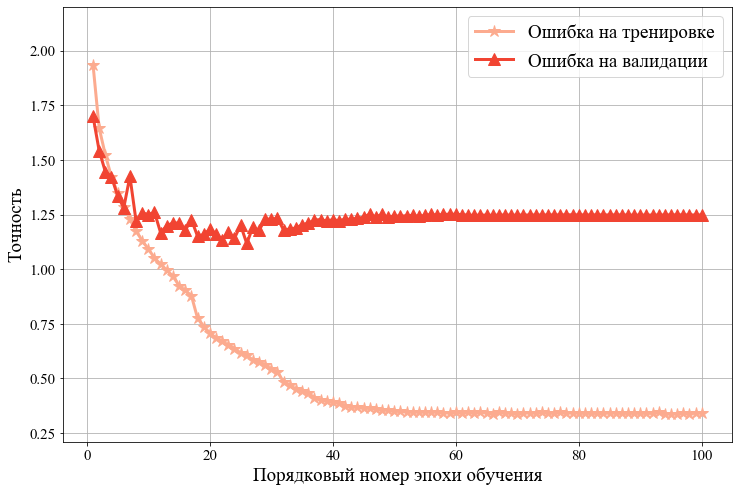

In [11]:
plt.rcParams.update({'font.size': 15})
plt.rcParams["font.family"] = "Times New Roman"

colors_1 = plt.cm.Blues(np.linspace(0.3, 0.6 , 2))
colors_2 = plt.cm.Reds(np.linspace(0.3, 0.6 , 2))

pylab.figure(1)
pylab.figure(figsize=(12, 8))
pylab.xlabel('Порядковый номер эпохи обучения', size=19)
x = np.array(range(1, len(train_hist.history['acc']) + 1))
# pylab.xticks(x)
pylab.ylabel('Точность', size=19)
pylab.grid()
pylab.ylim(.21, 2.2)
# ax.tick_params(axis='both', which='major', labelsize=100)

pylab.plot(x, train_hist.history['loss'], color=colors_2[0], marker='*', linewidth=3, markersize=12)
pylab.plot(x, train_hist.history['val_loss'], color=colors_2[1], marker='^', linewidth=3, markersize=12)

pylab.legend(['Ошибка на тренировке', 'Ошибка на валидации'], loc='upper right', prop={'size': 19})
    
save_name = f"../output/train_loss_{model.name}_s{str(stack_num)}_{cur_model_type}.png"
plt.savefig(save_name, dpi=200)
plt.show();

<Figure size 432x288 with 0 Axes>

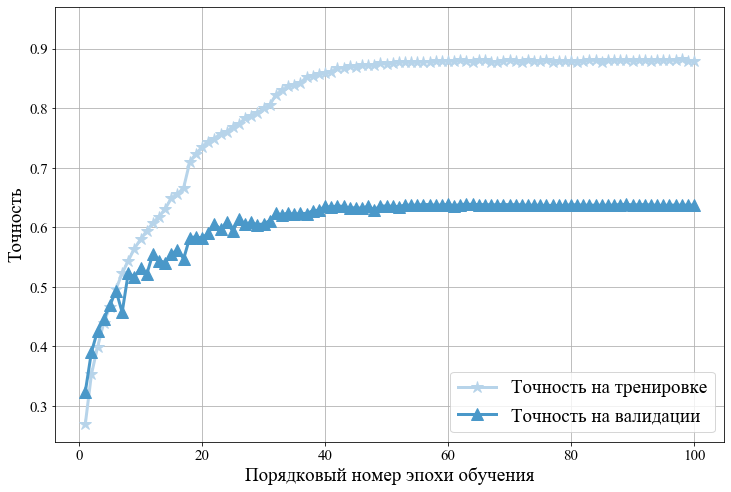

In [12]:
plt.rcParams.update({'font.size': 15})
plt.rcParams["font.family"] = "Times New Roman"

colors_1 = plt.cm.Blues(np.linspace(0.3, 0.6 , 2))
colors_2 = plt.cm.Reds(np.linspace(0.3, 0.6 , 2))

pylab.figure(1)
pylab.figure(figsize=(12, 8))
pylab.xlabel('Порядковый номер эпохи обучения', size=19)
x = np.array(range(1, len(train_hist.history['acc']) + 1))
# pylab.xticks(x)
pylab.ylabel('Точность', size=19)
pylab.grid()
pylab.ylim(.24, 0.97)
# ax.tick_params(axis='both', which='major', labelsize=100)

pylab.plot(x, train_hist.history['acc'], color=colors_1[0], marker='*', linewidth=3, markersize=12)
pylab.plot(x, train_hist.history['val_acc'], color=colors_1[1], marker='^', linewidth=3, markersize=12)

pylab.legend(['Точность на тренировке', 'Точность на валидации'], loc='lower right', prop={'size': 19})

save_name = f"../output/train_acc_{model.name}_s{str(stack_num)}_{cur_model_type}.png"
plt.savefig(save_name, dpi=200)
plt.show();

# Model Estimation

In [17]:
from sklearn.metrics import f1_score
from keras.models import load_model

In [24]:
model = load_model(weight_path)

ValueError: Cannot create group in read only mode.

In [22]:
# == CONFUSION MATRIX == 

# y_pred = model.predict([x_test, x_test_angle])
y_pred = model.predict(x_test)


conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

In [26]:
# == F1 SCORE == 

# y_pred = model.predict([x_test, x_test_angle])
y_pred = model.predict(x_test)


f1_score = f1_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average='weighted')
print(f1_score)

TypeError: 'numpy.float64' object is not callable

In [14]:
def plot_confusion_matrix(cm, normalize=False, cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.rcParams.update({'font.size': 15})
    plt.rcParams["font.family"] = "Times New Roman"
    # plt.colorbar()

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                size=17)

    plt.tight_layout()
    plt.ylabel('Верный класс', size=19, labelpad=.2)
    plt.xlabel('Предсказанный класс', size=19, labelpad=.2)

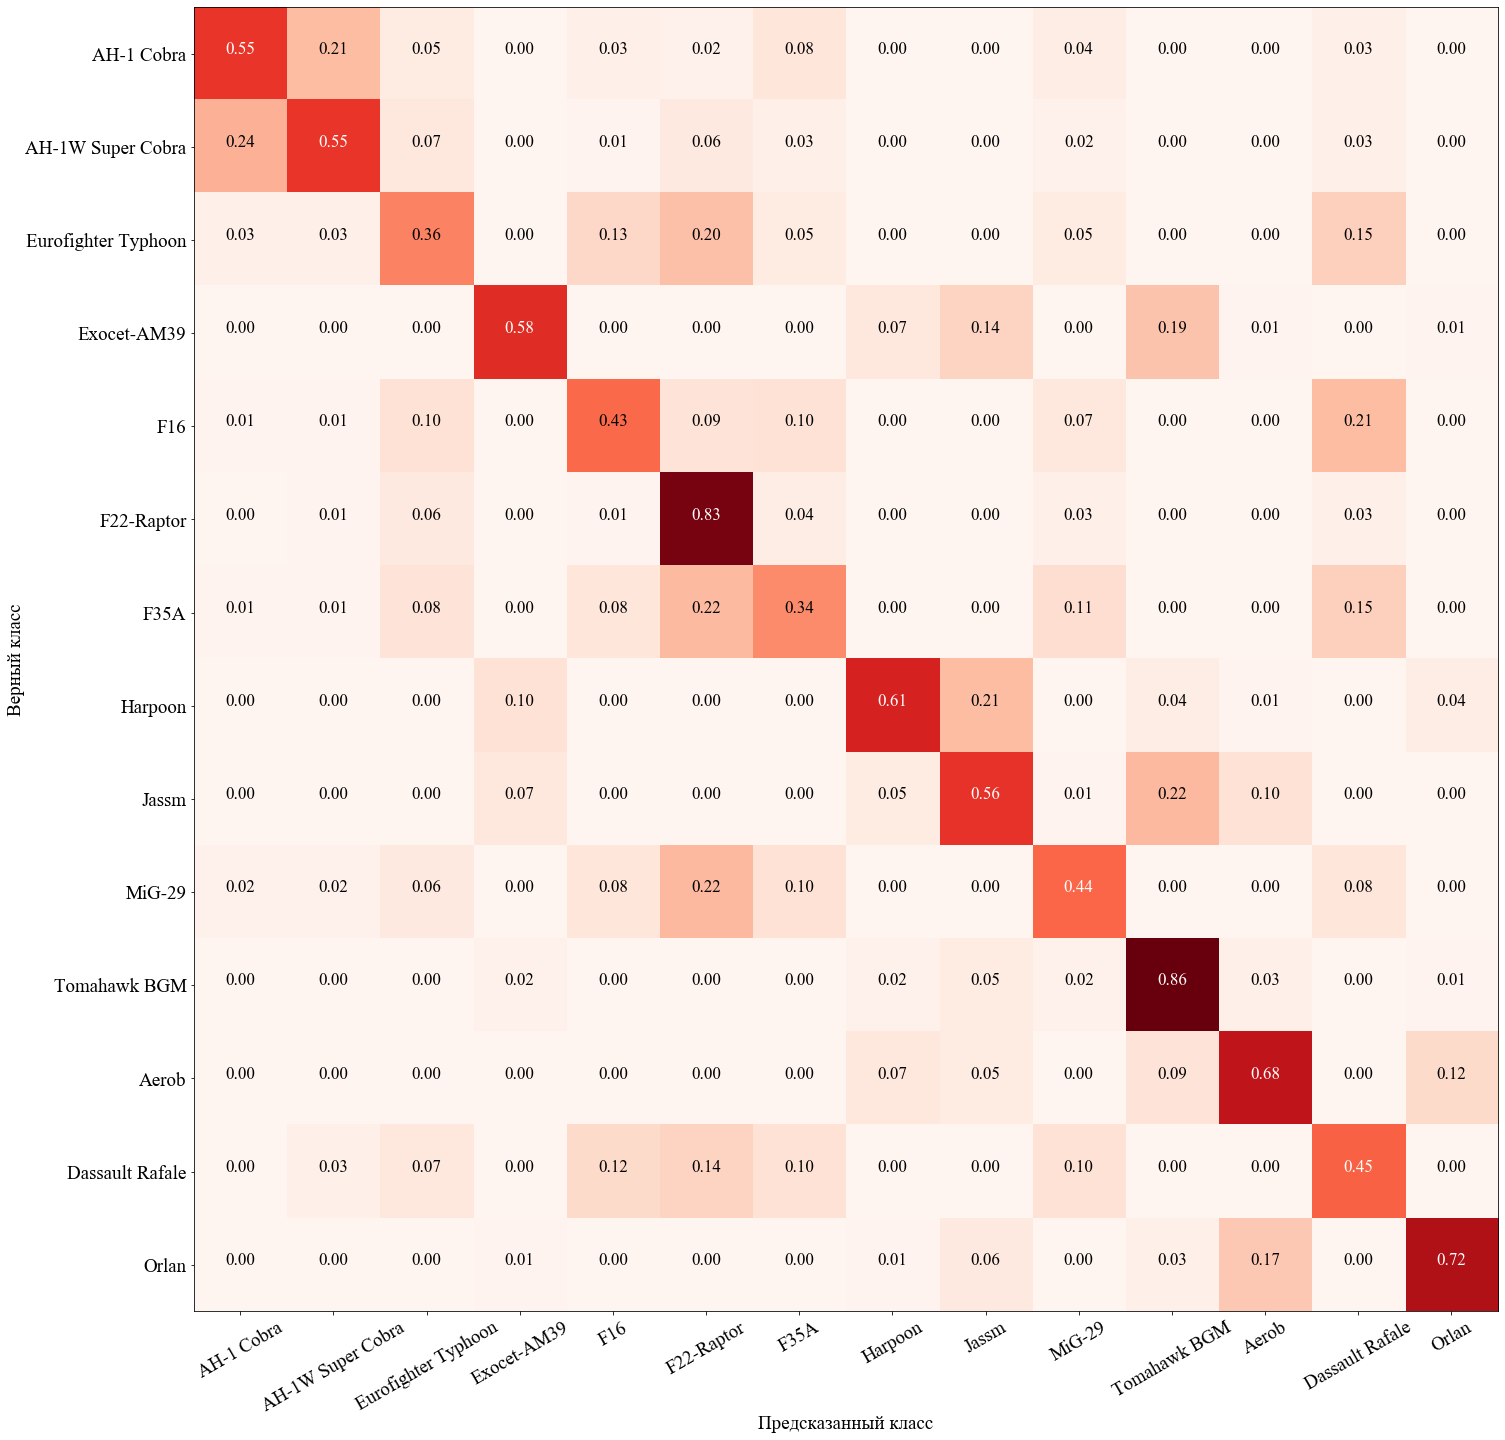

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22, 20))
types = ['drone', 'fighter', 'helicopter', 'missile']
types = types[:4]

all_classes = ['AH-1 Cobra', 'AH-1W Super Cobra', 'Eurofighter Typhoon',
               'Exocet-AM39', 'F16', 'F22-Raptor',
               'F35A', 'Harpoon', 'Jassm',
               'MiG-29', 'Tomahawk BGM', 'Aerob',
               'Dassault Rafale', 'Orlan']

l = np.arange(len(all_classes))
axes.set_yticks(l)
axes.set_yticklabels(all_classes, size=19)
axes.set_xticks(l)
axes.set_xticklabels(all_classes, rotation=30, size=19)

plt.subplot(axes)
plot_confusion_matrix(conf_matrix, normalize=True)

save_name = f"../output/conf_{model.name}_s{str(stack_num)}_{cur_model_type}.png"
plt.savefig(save_name, dpi=200)
plt.show();